In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import libraries neccecary for the code below
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# reading file generated from 5_bert_topic_modeling.ipynb
df_title = pd.read_csv('data/df_info_base.csv')
df_topic = pd.read_csv('data/nlp_output/title_topic_base.csv')

df_caption = pd.read_csv('data/df_caption_base2.csv')
df_topic2 = pd.read_csv('data/nlp_output/caption_topic_base2.csv')

# print the top 10 topics of title by views
df_title_top_topic = df_title.groupby('title_topic')['views'].mean().reset_index().sort_values('views', ascending=False)

df_title_top_topic = df_title_top_topic.head(10)['title_topic'].tolist()

for i in df_title_top_topic:
    print(df_topic[df_topic['Topic']==i][['Topic', 'Count', 'Name']])

    Topic  Count                                           Name
21     20     43  20_statquest_pca_principal_component analysis
   Topic  Count                                             Name
7      6     78  6_clearly explained_clearly_explained_live 2020
    Topic  Count                                          Name
74     73     12  73_gradient_part of_descent_gradient descent
    Topic  Count                                            Name
25     24     41  24_certificate_google_google data_professional
    Topic  Count                             Name
17     16     48  16_study_self_online_self study
    Topic  Count                            Name
41     40     25  40_day in_the life_life of_day
    Topic  Count                          Name
30     29     32  29_code_to code_gpt_learn to
    Topic  Count                 Name
48     47     20  47_m1_mac_pro_intel
   Topic  Count                                          Name
4      3     90  3_data analyst_analyst_to become_analys

In [7]:
# inspect df_title columns
df_title.columns

Index(['author', 'title', 'publish_date', 'views', 'likes', 'url', 'types',
       'length', 'keywords', 'description', 'id', 'title_char_count',
       'title_word_count', 'description_char_count', 'description_word_count',
       'days_since_last_video', 'days_since_first_video', 'keyword_count',
       'has_keyword', 'title_topic', 'image'],
      dtype='object')

In [5]:
# drop columns that are not needed from column 21 to 103
df_title = df_title.drop(df_title.columns[20:104], axis=1)

In [8]:
# inspect df_caption.coulumns
df_caption.columns

Index(['id', 'json_caption', 'caption', 'caption_char_count',
       'caption_word_count', 'author', 'title', 'publish_date', 'views',
       'likes', 'url', 'types', 'length', 'keywords', 'description',
       'title_char_count', 'title_word_count', 'description_char_count',
       'description_word_count', 'days_since_last_video',
       'days_since_first_video', 'keyword_count', 'has_keyword',
       'caption_topic', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53'],
      dtype='object')

In [9]:
# merge df_title and df_caption[['id', 'caption_topic']] on id to get the caption topic

df_title = df_title.merge(df_caption[['id', 'caption_topic']], on='id', how='left')

In [10]:
# rename Topic column to title_topic and caption_topic
df_topic.rename(columns={'Topic':'title_topic'}, inplace=True)
df_topic2.rename(columns={'Topic':'caption_topic'}, inplace=True)

# drop 'Unnamed: 0' column
df_topic = df_topic.drop(df_topic.columns[0], axis=1)
df_topic2 = df_topic2.drop(df_topic2.columns[0], axis=1)

In [11]:
# null value in caption_topic is due to subtitle disabled in videos 
df_title['caption_topic'].isna().sum()

292

# Correlation to determine if likes are correlated to views

C:\Users\danie\AppData\Local\Temp/ipykernel_21616/20855484.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_title.corr(), annot=True, cmap='coolwarm')


<AxesSubplot:>

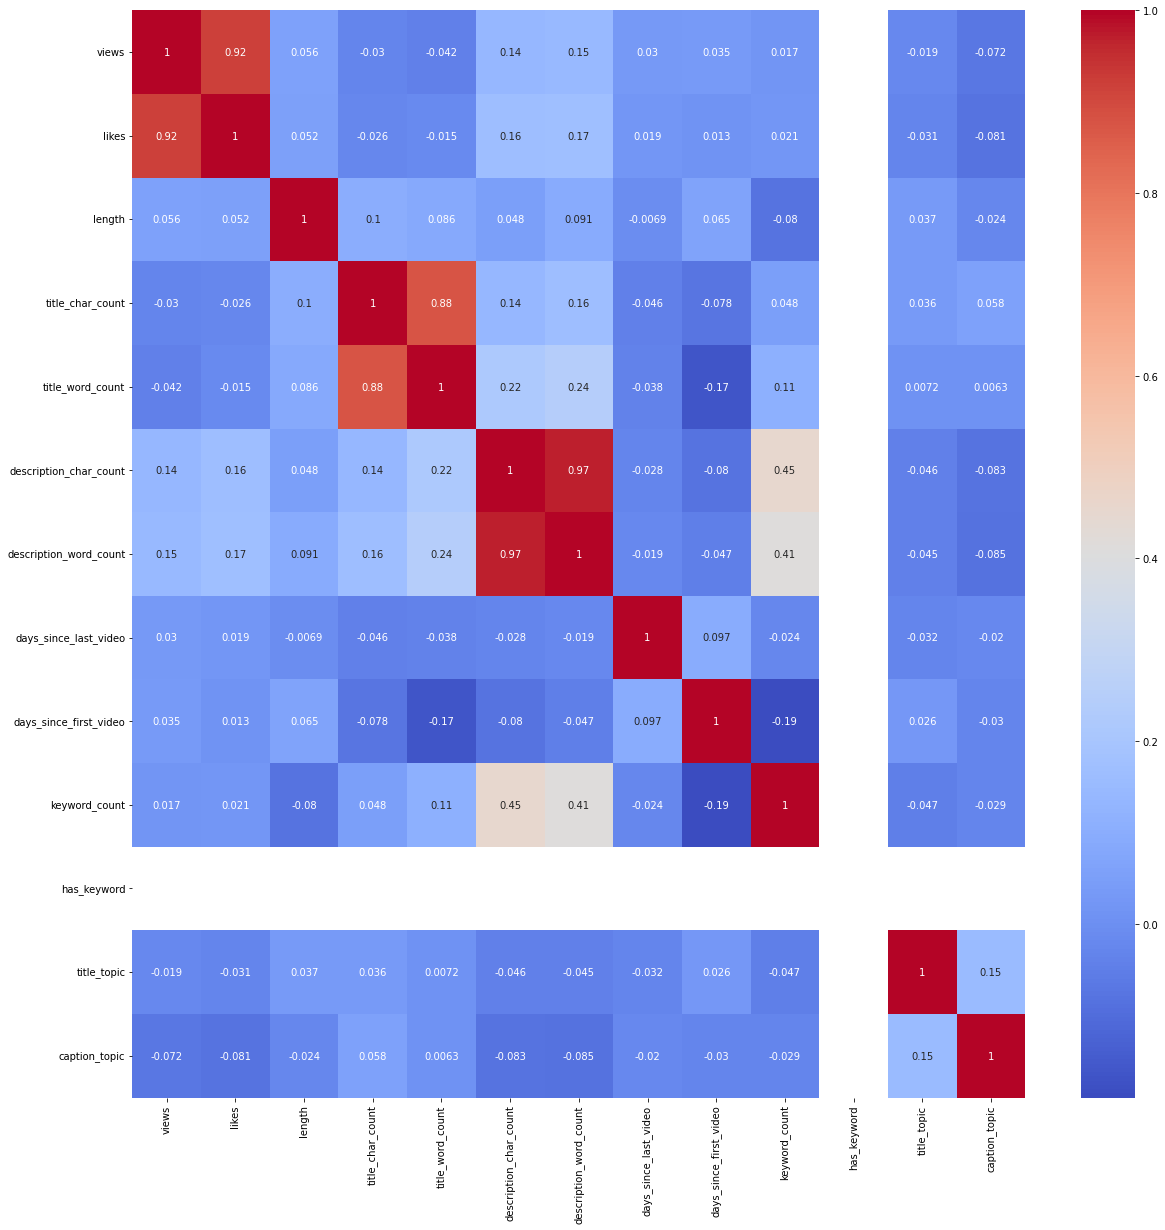

In [13]:
# visualize the correlation between the features
plt.figure(figsize=(20,20))
sns.heatmap(df_title.corr(), annot=True, cmap='coolwarm')

<AxesSubplot:>

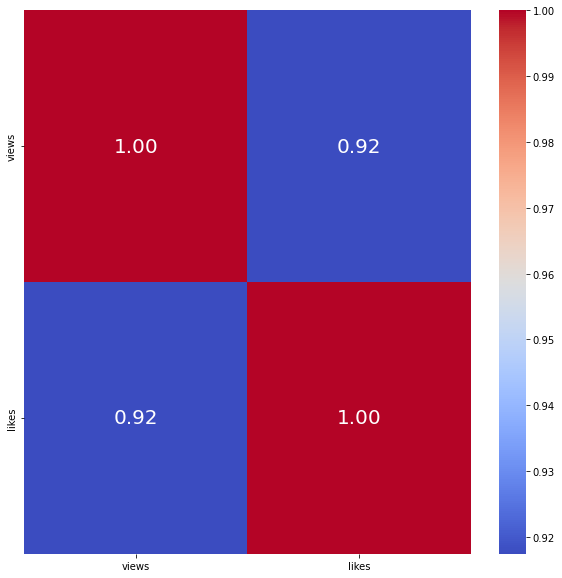

In [16]:
# visualize the correlation between views and likes with bigger labels and values
plt.figure(figsize=(10,10))
sns.heatmap(df_title[['views', 'likes']].corr(), annot=True, cmap='coolwarm', annot_kws={"size": 20}, fmt='.2f')


# Baseline model (KNN)

In [17]:
# perform linear regression with views as independent variable and likes as dependent variable
X = df_title[['views']]
y = df_title['likes']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# create baseline model using knn
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# predict y using X_test
y_pred = knn.predict(X_test)

# calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# calculate r^2 score
r2 = r2_score(y_test, y_pred)

# print the results
print('MAE: ', mae)
print('R^2: ', r2)

MAE:  480.6907133243608
R^2:  0.7442446174144077


# pipeline to run 4 other model for comparison

In [29]:
# Create pipelines with standard scaler
pipelines = {
    'lr': Pipeline([('scaler', StandardScaler()), 
                    ('lr', LinearRegression())]),
    'rf': Pipeline([('scaler', StandardScaler()), 
                    ('rf', RandomForestRegressor(random_state=123))]),
    'dt': Pipeline([('scaler', StandardScaler()), 
                    ('dt', DecisionTreeRegressor(random_state=123))]),
    'knn': Pipeline([('scaler', StandardScaler()), 
                     ('knn', KNeighborsRegressor())]),
    'gb': Pipeline([('scaler', StandardScaler()), 
                    ('gb', GradientBoostingRegressor(random_state=123))])
}

# Train models and evaluate performance on test set
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} pipeline test set performance:')
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R^2: {r2:.3f}\n')

lr pipeline test set performance:
MSE: 1511925.631
MAE: 395.606
R^2: 0.868

rf pipeline test set performance:
MSE: 4765690.715
MAE: 577.634
R^2: 0.583

dt pipeline test set performance:
MSE: 6940440.201
MAE: 673.844
R^2: 0.392

knn pipeline test set performance:
MSE: 2921477.749
MAE: 480.813
R^2: 0.744

gb pipeline test set performance:
MSE: 4605743.588
MAE: 519.963
R^2: 0.597



In [30]:
# add new columns predicted_likes to df_title
df_title['predicted_likes'] = pipelines['lr'].predict(X)

In [31]:
df_title[['likes', 'predicted_likes']].head(10)

,likes,predicted_likes
0,1282,790.371893
1,268,225.191739
2,2001,1721.761710
3,365,409.928466
4,1475,1828.892693
5,3009,3013.740213
6,1707,1407.651854
7,485,336.644226
8,150,247.010799
9,480,663.476830


Text(0.5, 1.0, 'Likes vs Views')

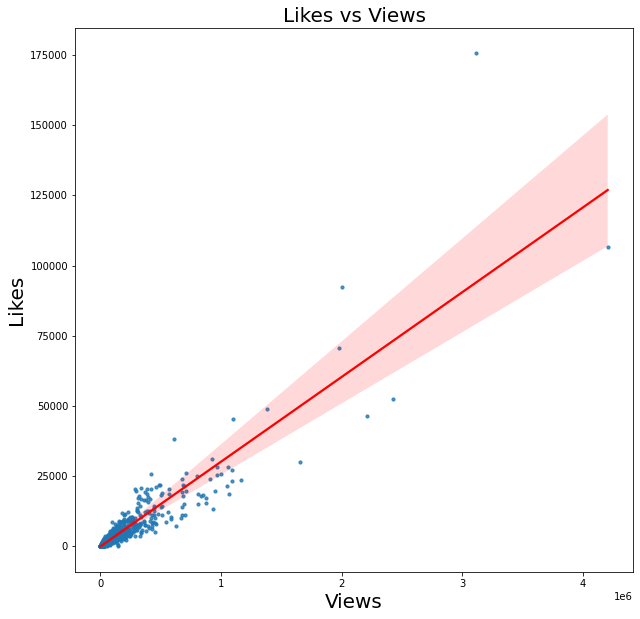

In [40]:
# plot the ikes as y and views as x using seaborn with regression line

plt.figure(figsize=(10,10))
sns.regplot(x='views', y='likes', data=df_title, line_kws={'color': 'red'}, scatter_kws={'s': 10}, label='Likes')
plt.xlabel('Views', fontsize=20)
plt.ylabel('Likes', fontsize=20)
plt.title('Likes vs Views', fontsize=20)




In [41]:
# counts row with predicted_likes < likes
df_title[df_title['predicted_likes'] < df_title['likes']].shape

(1791, 23)

In [89]:
# add new columns engagement3 to df_title whichc is likes minus predicted_likes
df_title['quality'] = df_title['likes'] - df_title['predicted_likes']

In [132]:
profession = pd.read_csv('data/youtuber_summary.csv')
# sort list of authors from nunique of df_title['author']
author = df_title['author'].value_counts().reset_index().sort_values('index', ascending=True)
# rename columns
author.rename(columns={'index':'author', 'author':'count'}, inplace=True)
author.reset_index(drop=True, inplace=True)

# create new column author_id which running number from 1 to 30
author['author_id'] = author.index + 1

df_title = df_title.merge(author[['author', 'author_id']], on='author', how='left')

# create new column quality_bool which is Quality if quality > 0 and Not Quality if quality < 0
df_title['quality_cat'] = np.where(df_title['quality'] > 0, 'Quality', 'Not Quality')

KeyError: 'quality'

In [163]:
# fill na of column description with 'No Description'
df_title['description'] = df_title['description'].fillna('No Description')

In [140]:
# export df_title, df_topic, df_topic2 to csv for power bi dashbording
df_title.to_csv('data/main_bi.csv', index=False)
df_topic.to_csv('data/title_topic_bi.csv', index=False)
df_topic2.to_csv('data/caption_topic_bi.csv', index=False)